# Evaluate Stanford Quality Control Criteria
- Code author: Sahar H. El Abbadi
- Date started: 2022-03-02
- Date last edited: 2022-03-22

### Summary of Stanford QC Criteria

Stanford wind exclusion criteria aims to ensure that a given plume of gas used for testing is not contaminated by prior gas released. We use a distance threshold of X (in meters from release point) to evaluate whether gas from previous releases is close enough to the current plume to be visible to airplane operators. We set a technology-specific distance threshold based on the ability of the airplanes to observe plumes of different lengths.
This was determined hyperspectral images reported or soon-to-be reported in the literature:
- Kairos – 500 m – hyperspectral images from Sherwin, Chen et al., 2021
- Carbon Mapper – 300 m – based on the maximum fetch distance of 150 m used by Carbon Mapper, as reported in Duren et al., 2019 supplemental information. We double this distance to add buffer
- GHGSAT – 300 m – based on hyperspectral images provided to Stanford Team by GHGSAT during 2021 Controlled Release testing, to be published in Rutherford et al, 2023.
- MAIR – 500 m – based on hyperspectral images in draft of Chulakadabba et al., to be submitted soon as of Feb 2023

For each plume and each airplane overpass, we look at the 10 minutes prior to a given overpass, and consider all gas during this 10-minute period that is not part of the current plume. It may be part of one or multiple prior plumes, or from gas released during non-testing periods. Using 3-D wind data collected onsite, we calculate the total mass $M_{10}$ not from the current plume, released in the ten minutes prior to the overpass, that lies within the distance threshold X (described above). We also calculate the total mass $M_o$, which is the mass of gas from the current plume up until the overpass in question. If $M_{10}$ is greater than the mass threshold of 10% of $M_o$, we consider the overpass does not meet our quality criteria and is considered potentially contaminated by gas from previous releases. We thus remove the overpass from the dataset of valid overpasses.

The current approach assume gas particles are transported according to the wind vector and are not subject to other forces of dispersion/diffusion. Thus, we recognize this approach is inherently conservative as $M_{10}$ is a theoretical maximum value and not reflective of real-world conditions. As a result, we choose a slightly less conservate mass percent threshold (10%).However, this means we are knowingly evaluating operators on overpasses in which up to 10% of the mass in their field of view may not be from the current release.

Here, we calculate the error profile for all operators using a 10% and 1% mass thresholds. We compare overpasses which are kept using both mass thresholds, discarded using both mass thresholds, and kept in 10% but discarded in 1%. If we observe a statistically significant difference in error threshold across these three groups using a t-test with a p-value of 0.05, we will reanalyze the data using a 5% and 1% error threshold.

### Using this notebook:
- In this notebook, the "lax" QC criteria refers to the 10% mass critieria
- The "strict" QC criteria refers to the 1% mass criteria

In [1]:
# TODO add description of how we removed overpasses if they were at the transition point between releases rates

In [2]:
# Setup
import pathlib
import pandas as pd
from methods_source import make_qc_table
from plot_methods import plot_qc_summary
from methods_error_calculations import evaluate_error_profile


## Compare Operator vs Stanford QC

In [3]:
qc_summary_strict = make_qc_table(strict_discard=True)
qc_summary_lax = make_qc_table(strict_discard=False)

# print summary columns only '
print_col = ['operator', 'total_overpasses', 'pass_all_qc', 'fail_stanford_only', 'fail_operator_only', 'fail_all_qc']
print(f'Summary of filtering with Stanford strict QC:\n')
print(qc_summary_strict.query('stage==1')[print_col])

Summary of filtering with Stanford strict QC:

      operator  total_overpasses  pass_all_qc  fail_stanford_only  \
0           cm               121           78                   7   
0          ghg               198          123                  69   
0       kairos               349          171                 110   
0  kairos_ls23               349          167                 107   
0  kairos_ls25               349          170                 109   
0        sciav                18           11                   0   
0         mair                24           18                   6   

   fail_operator_only  fail_all_qc  
0                  30            6  
0                   1            5  
0                  31           37  
0                  35           40  
0                  32           38  
0                   7            0  
0                   0            0  


In [4]:
print(f'Summary of filtering with Stanford lax QC:\n')
print(qc_summary_lax.query('stage==1')[print_col])

Summary of filtering with Stanford lax QC:

      operator  total_overpasses  pass_all_qc  fail_stanford_only  \
0           cm               121           82                   3   
0          ghg               198          140                  52   
0       kairos               349          191                  90   
0  kairos_ls23               349          186                  88   
0  kairos_ls25               349          190                  89   
0        sciav                18           11                   0   
0         mair                24           20                   4   

   fail_operator_only  fail_all_qc  
0                  31            5  
0                   1            5  
0                  39           29  
0                  44           31  
0                  40           30  
0                   7            0  
0                   0            0  


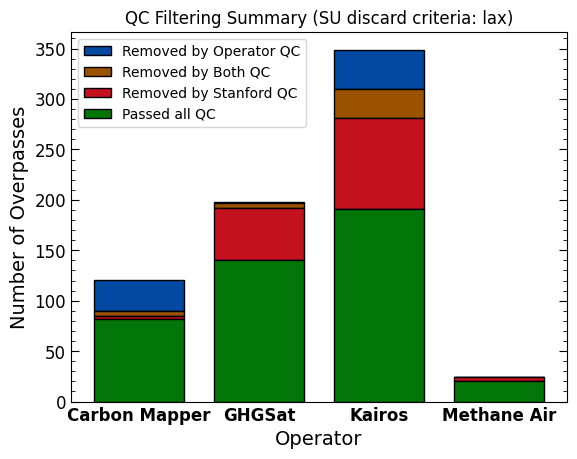

In [5]:
# Make bar pot summarizing QC results with lax discard criteria
operators = ['Carbon Mapper', 'GHGSat', 'Kairos', 'Methane Air']
stage = 1
plot_qc_summary(operators, stage, strict_discard = False)

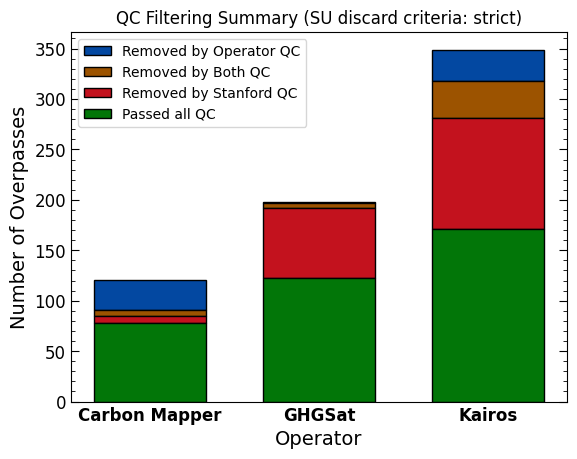

In [6]:
# Make bar pot summarizing QC results with lax discard criteria
operators = ['Carbon Mapper', 'GHGSat', 'Kairos']
stage = 1
plot_qc_summary(operators, stage, strict_discard = True)

## QC Filter and error profile

Compare strict and non-strict QC filters and error profile for operators.

First, make a dataframe that summarizes overpasses and includes percent error for each quantified overpasses. This dataframe includes all overpasses, and reports nan in the percent error column when release_rate_kgh is 0 kgh, or when operator_quantification is not reported.

Percent error is calculated as:

$$
    Percent Error = \frac{|(operator\_quantification) - (release\_rate\_kgh)|}{release\_rate\_kgh}
$$


### Carbon Mapper

In [7]:
# Evaluate percent error for Carbon Mapper, Stage 1
operator = 'Carbon Mapper'
stage = 1

cm_error_profile, cm_p_values = evaluate_error_profile(operator, stage)

Evaluate Carbon Mapper percent error using Stanford strict QC criteria: 
-There are 67 overpasses that Carbon Mapper quantified which pass the Stanford strict QC criteria
-Percent error for Carbon Mapper on overpasses that are included in the strict criteria is: 55.57%

Evaluate Carbon Mapper percent error using Stanford lax QC criteria: 
-There are 71 overpasses that Carbon Mapper quantified which pass the Stanford lax QC criteria
-Percent error for Carbon Mapper on overpasses that are included in the lax criteria is: 57.42%

Evaluate Carbon Mapper percent error for overpasses that passed the lax criteria and failed the strict criteria:
-There are 4 overpasses that Carbon Mapper quantified which pass the Stanford lax QC criteria but fail the Stanford strict
-Carbon Mapper mean percent error for overpasses kept in the lax criteria but discarded in strict is: 88.35%

Compare the strict discard criteria with the lax criteria:
-The calculated p-value of 0.9048 is greater than 0.05, the di

### GHGSat

In [8]:
# Evaluate percent error for GHGSat, Stage 1
operator = 'GHGSat'
stage = 1

ghg_error_profile, ghg_p_values = evaluate_error_profile(operator, stage)

Evaluate GHGSat percent error using Stanford strict QC criteria: 
-There are 104 overpasses that GHGSat quantified which pass the Stanford strict QC criteria
-Percent error for GHGSat on overpasses that are included in the strict criteria is: 36.88%

Evaluate GHGSat percent error using Stanford lax QC criteria: 
-There are 121 overpasses that GHGSat quantified which pass the Stanford lax QC criteria
-Percent error for GHGSat on overpasses that are included in the lax criteria is: 36.81%

Evaluate GHGSat percent error for overpasses that passed the lax criteria and failed the strict criteria:
-There are 17 overpasses that GHGSat quantified which pass the Stanford lax QC criteria but fail the Stanford strict
-GHGSat mean percent error for overpasses kept in the lax criteria but discarded in strict is: 36.37%

Compare the strict discard criteria with the lax criteria:
-The calculated p-value of 0.9886 is greater than 0.05, the difference between the two complete overpass sets is not stati

### Kairos

In [9]:
# Evaluate percent error for Kairos, Stage 1
operator = 'Kairos'
stage = 1

kairos_error_profile, kairos_p_values = evaluate_error_profile(operator, stage)

Evaluate Kairos percent error using Stanford strict QC criteria: 
-There are 171 overpasses that Kairos quantified which pass the Stanford strict QC criteria
-Percent error for Kairos on overpasses that are included in the strict criteria is: 41.70%

Evaluate Kairos percent error using Stanford lax QC criteria: 
-There are 191 overpasses that Kairos quantified which pass the Stanford lax QC criteria
-Percent error for Kairos on overpasses that are included in the lax criteria is: 44.28%

Evaluate Kairos percent error for overpasses that passed the lax criteria and failed the strict criteria:
-There are 20 overpasses that Kairos quantified which pass the Stanford lax QC criteria but fail the Stanford strict
-Kairos mean percent error for overpasses kept in the lax criteria but discarded in strict is: 61.68%

Compare the strict discard criteria with the lax criteria:
-The calculated p-value of 0.6513 is greater than 0.05, the difference between the two complete overpass sets is not stati

### Methane Air

In [10]:
# Evaluate percent error for Methane Air, Stage 1
operator = 'Methane Air'
stage = 1

mair_error_profile, mair_p_values = evaluate_error_profile(operator, stage)

Evaluate Methane Air percent error using Stanford strict QC criteria: 
-There are 18 overpasses that Methane Air quantified which pass the Stanford strict QC criteria
-Percent error for Methane Air on overpasses that are included in the strict criteria is: 45.83%

Evaluate Methane Air percent error using Stanford lax QC criteria: 
-There are 20 overpasses that Methane Air quantified which pass the Stanford lax QC criteria
-Percent error for Methane Air on overpasses that are included in the lax criteria is: 42.59%

Evaluate Methane Air percent error for overpasses that passed the lax criteria and failed the strict criteria:
-There are 2 overpasses that Methane Air quantified which pass the Stanford lax QC criteria but fail the Stanford strict
-Methane Air mean percent error for overpasses kept in the lax criteria but discarded in strict is: 16.71%

Compare the strict discard criteria with the lax criteria:
-The calculated p-value of 0.8495 is greater than 0.05, the difference between t

### Summarize Results

#### Summary of Error Profile

Summarize percent error for all operators accross the different QC criteria in one table. Entries are in percent.
- strict = all overpasses quantified by operator that pass the strict Stanford QC threshold criteria
- lax = all overpasses quantified by operator that pass the lax Stanford QC threshold criteria
- lax_not_strict: all overpasses quantified by the operator that meet the lax Stanford QC threshold critiera but fail the  strict QC threshold criteria

In [11]:
op_index = ['Carbon Mapper', 'GHGSat', 'Kairos', 'Methane Air']
error_dictionaries = [cm_error_profile, ghg_error_profile, kairos_error_profile, mair_error_profile]
error_summary = pd.DataFrame.from_records(error_dictionaries, index=op_index)
error_summary.to_csv(pathlib.PurePath('03_results', 'overpass_error', 'percent_error_summary.csv'))
print('Table of percent error: ')
print(error_summary.to_string(float_format='{:.2f}%'.format))

Table of percent error: 
               strict    lax  lax_not_strict
Carbon Mapper  55.57% 57.42%          88.35%
GHGSat         36.88% 36.81%          36.37%
Kairos         41.70% 44.28%          61.68%
Methane Air    45.83% 42.59%          16.71%


#### Summarize T-Test results
Summarize results of t-test comparing percent error for operator performance using different QC threshold
- strict_v_lax: compares percent error for overpasses that pass strict QC criteria with overpasses that pass the lax QC criteria
- strict_v_lax_not_strict: compares overpasses that pass the strict criteria with those that pass lax but not the strict criteria

In [12]:
op_index = ['Carbon Mapper', 'GHGSat', 'Kairos', 'Methane Air']
p_dictionaries = [cm_p_values, ghg_p_values, kairos_p_values, mair_p_values]
error_summary = pd.DataFrame.from_records(p_dictionaries, index=op_index)
error_summary.to_csv(pathlib.PurePath('03_results', 'overpass_error', 't-test_results.csv'))
print('Table of p-values from t-test comparison: ')
print(error_summary.to_string(float_format='{:.3f}'.format))

Table of p-values from t-test comparison: 
               strict_v_lax  strict_v_lax_not_strict
Carbon Mapper         0.905                    0.484
GHGSat                0.989                    0.959
Kairos                0.651                    0.091
Methane Air           0.850                    0.438


### Compare Parity Plots
Both Kairos and Carbon Mapper show increased % error in "lax_not_strict" compared to "strict" overpasses. However, these values are not statistically signficantly using a p-value of 0.05 on a 2-tail student's t-test. Thus, while we use the lax criteria in the main manuscript, here we provide results for Kairos and Carbon Mapper using the strict criteria.

#### Kairos

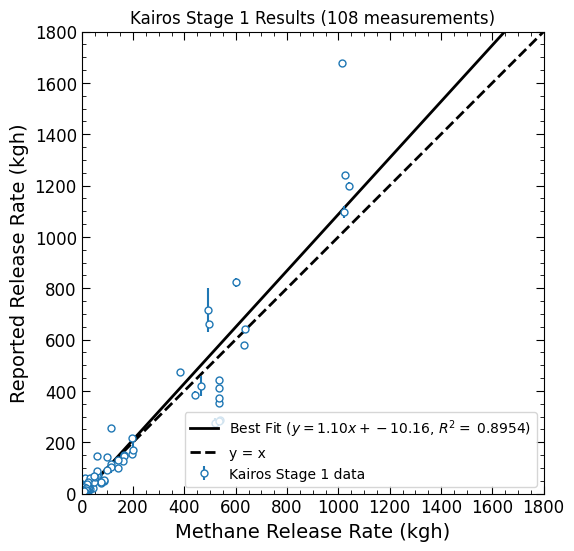

In [13]:
from plot_methods import plot_parity
# Kairos Combo Stage 1

# Info for plotting
operator = 'Kairos'
stage = 1

# Make parity plot for strict discard
plot_parity(operator, stage, strict_discard=True)

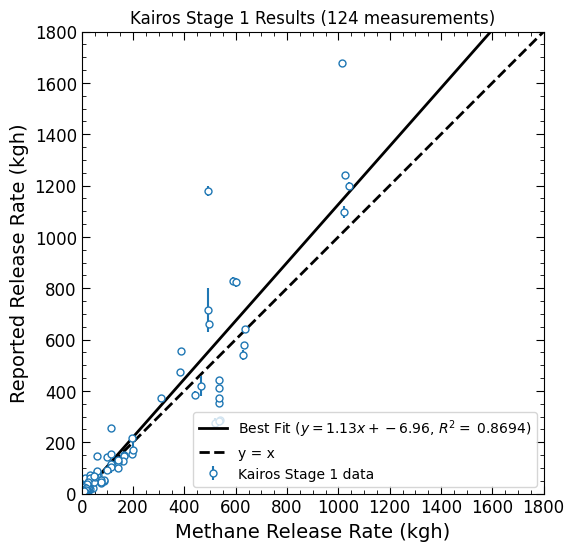

In [14]:
# Info for plotting
operator = 'Kairos'
stage = 1

# Make parity plot for lax discard
plot_parity(operator, stage, strict_discard=False)

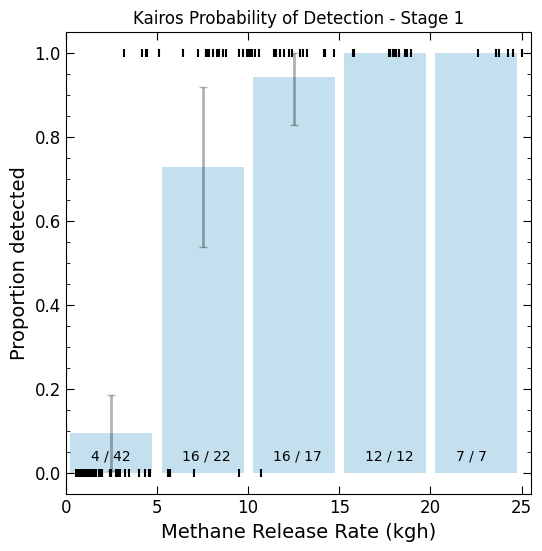

In [15]:
# Kairos probability of detection with strict discard
from plot_methods import plot_detection_limit

operator = 'Kairos'
stage = 1
n_bins = 5
threshold = 25
plot_detection_limit(operator, stage, n_bins=n_bins, threshold=threshold, strict_discard=True)

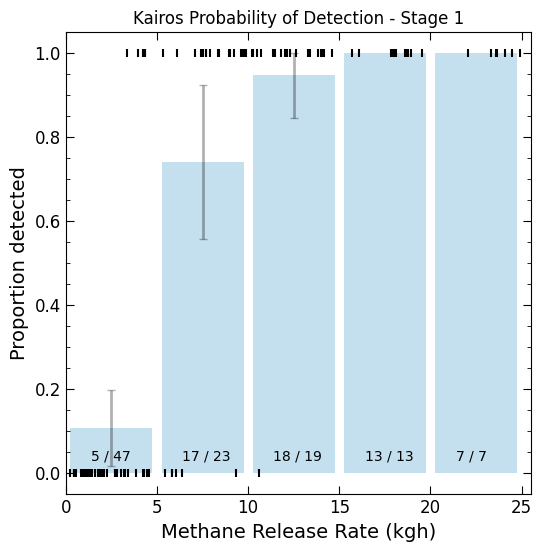

In [16]:
# Lax discard criteria

operator = 'Kairos'
stage = 1
n_bins = 5
threshold = 25
plot_detection_limit(operator, stage, n_bins=n_bins, threshold=threshold, strict_discard=False)

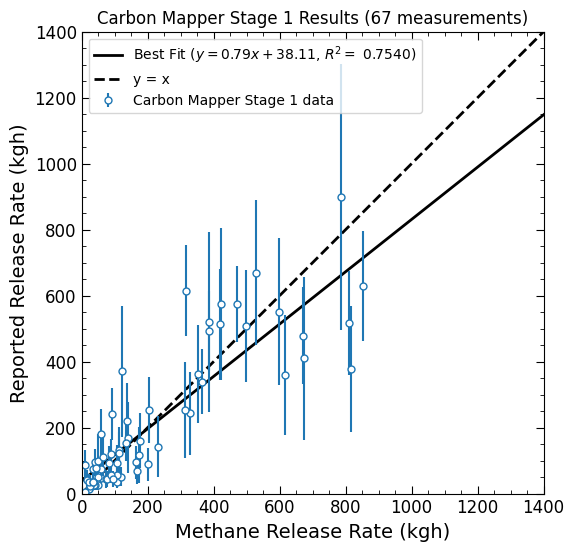

In [17]:
# Carbon Mapper Stage 1 with Strict Discard

# Info for plotting
operator = 'Carbon Mapper'
stage = 1

# Make parity plot for strict discard
plot_parity(operator, stage, strict_discard=True)

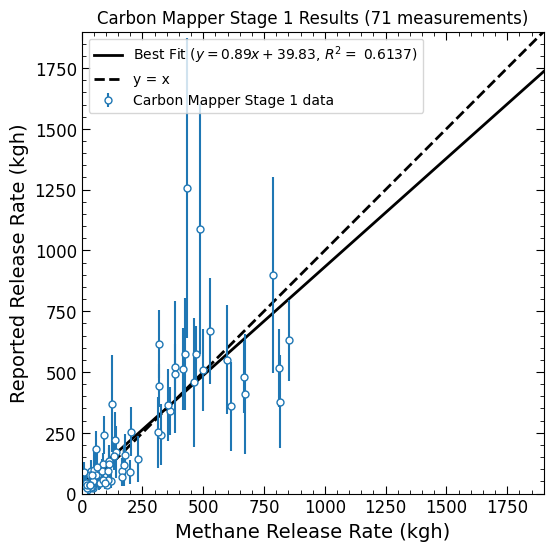

In [18]:
# Carbon Mapper Stage 1 with Lax Discard

# Info for plotting
operator = 'Carbon Mapper'
stage = 1

# Make parity plot for strict discard
plot_parity(operator, stage, strict_discard=False)

In [19]:
# Find overpasses that failed the lax criteria but passed the strict
from methods_source import make_overpass_error_df
cm_error_df = make_overpass_error_df(operator='Carbon Mapper', stage=1)
cm_lax_not_strict = cm_error_df.query('stanford_kept_strict == False & stanford_kept_lax == True')
print(cm_lax_not_strict)

     overpass_id  zero_release  operator_kept  operator_detected  \
71          72.0         False           True               True   
72          73.0         False           True               True   
105        106.0         False          False               True   
106        107.0         False           True               True   
116        117.0         False           True               True   

     operator_quantified  operator_quantification  release_rate_kgh  \
71                  True              1087.518445        485.566941   
72                  True              1256.739659        433.650411   
105                False                      NaN        622.693717   
106                 True               457.584404        460.894102   
116                 True               443.587403        319.346303   

     stanford_kept_strict qc_summary_strict  stanford_kept_lax qc_summary_lax  \
71                  False     fail_stanford               True       pass_all   
72